In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from control import *
from control import matlab

In [3]:
r1 = 10E3
r2 = 15E3
c1 = 1E-6
c2 = 1E-6

In [4]:
# 1) Crear una planta mediante los coeficientes del denominador y numerador en el tiempo continuo
s = tf('s') # Crea el operador diferencial S que se utiliza en las funciones transferencia
h_s = 1 / (1 + r1*c1*r2*c2*s*s + (r1*c1 + r2*c2 + r1*c2)*s)
num, den = tfdata(h_s)
print(num,den)

# 2) Crear una planta mediante matrices de estados que la definen (A, B, C y D)
# Se tiene que usar una conversion hecha por la libreria control con tf2ss (transfer function to state space)
# Se separa numerador y denominador de la funcion transferencia primero (esto se hizo con tfdata)
h_ss = tf2ss(num,den)
print(h_ss)


[[array([1])]] [[array([1.5e-04, 3.5e-02, 1.0e+00])]]
<StateSpace>: sys[10]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[-2.33333333e+02 -6.66666667e+03]
     [ 1.00000000e+00  0.00000000e+00]]

B = [[1.]
     [0.]]

C = [[   0.         6666.66666667]]

D = [[0.]]



In [6]:
# 3) Discretizar las anteriores plantas
# Para discretizar primero se tiene que definir un h que es el tiempo entre muestra y muestra
sys = ss2tf(h_ss.A,h_ss.B,h_ss.C,h_ss.D)
h = 0.1
#(Funcion transferencia continua, periodo de muestreo, tipo de retardo)
hz = matlab.c2d(h_s, h, 'zoh')

# Obtengo los valores de numerador y denominador
numz, denz = tfdata(hz)
print(numz,denz)

# Obtengo la ecuacion en espacio de estados
h_sz = tf2ss(hz)
print(h_sz)

[[array([0.95719121, 0.0071348 ])]] [[array([ 1.00000000e+00, -3.56739954e-02,  7.35295804e-11])]]
<StateSpace>: sys[9]$sampled$converted
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 3.56739954e-02 -7.35295804e-11]
     [ 1.00000000e+00  0.00000000e+00]]

B = [[1.]
     [0.]]

C = [[0.95719121 0.0071348 ]]

D = [[0.]]

dt = 0.1



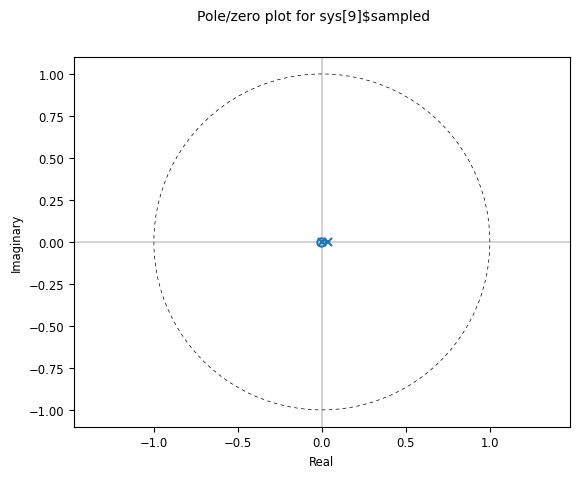

In [7]:
# 4) Evaluar la distribucion de polos y ceros de las plantas continuas y discretas, tambien su respuesta en frecuencia
# Polos y ceros en tiempo discreto
# polosz, cerosz = pzmap(hz)
# print("polos",polosz,"ceros",cerosz)

polosz, cerosz = pzmap(hz)[0]
# print(type(ret))


polos [<matplotlib.lines.Line2D object at 0x0000018363EC9F90>] ceros []


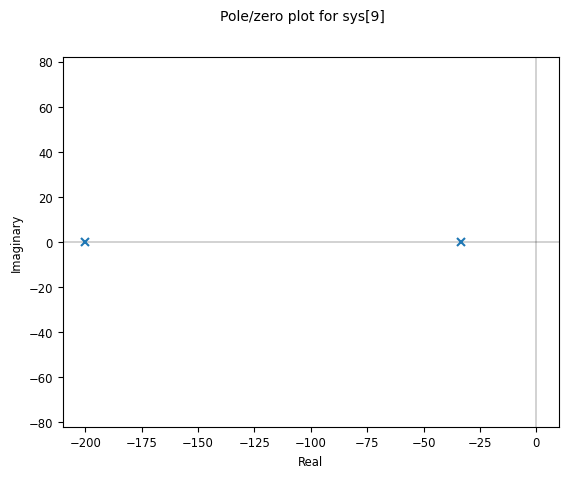

In [10]:
# Polos y ceros en el tiempo continuo
polosc, cerosc = pzmap(h_s)[0]
print("polos",polosc,"ceros",cerosc)

array([[list([<matplotlib.lines.Line2D object at 0x0000018363F2AD40>])],
       [list([<matplotlib.lines.Line2D object at 0x0000018363F2AFB0>])]],
      dtype=object)

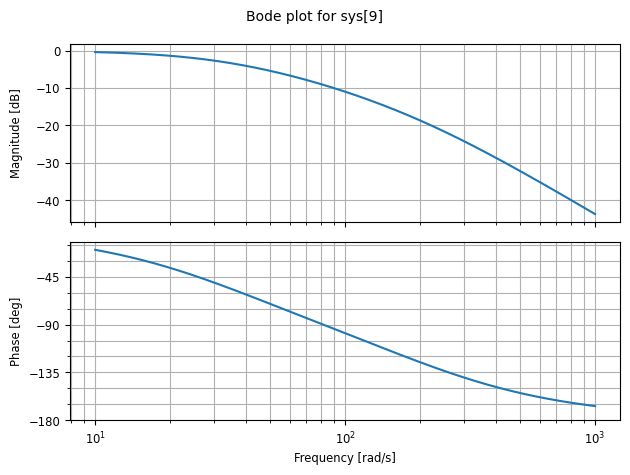

In [11]:
# Respuesta en frecuencia del sistema en tiempo continuo
bode_plot(h_s)

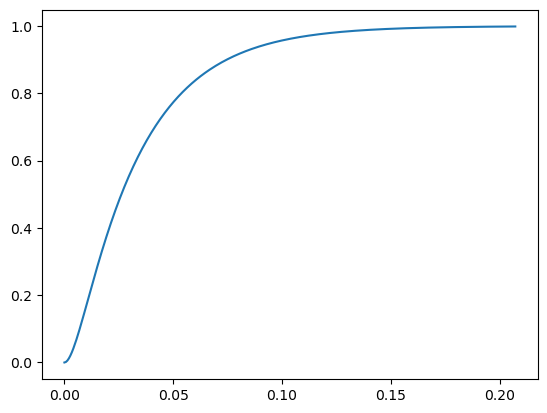

In [12]:
# 5) Evaluar la respuesta al escalon de todas las plantas, continuas y discretas
# Tiempo continuo
t, out = step_response(h_s)
plt.plot(t, out)

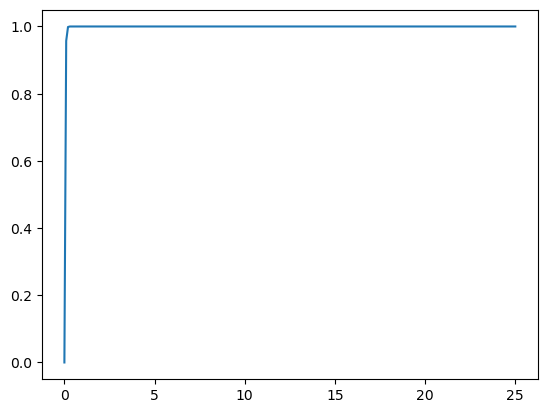

In [13]:
# Tiempo discreto
t, out = step_response(hz)
plt.plot(t, out)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

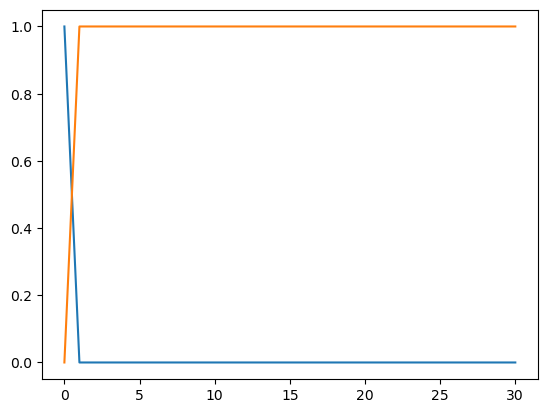

In [14]:
# 6) Crear una funcion que aplique la ecuacion de recurrencia de un filtro a una entrada cualquiera
# def funcion_recurrencia(num: np.ndarray, den: np.ndarray, input: np.ndarray) -> np.ndarray:
#     # len(num), len(den)
#     u = input
#     b = num
#     a = den
#     num_len = len(num)
#     den_len = len(den)
#     y = np.zeros(len(u))

#     # a = np.flip(a)

#     print("coefs b -> {}".format(num))
#     print("coefs a -> {}".format(den))
#     # Para el denominador o los Bn
#     # den[0]*input[n] + den[1]*input[n-1] + den[2]*input[n-2] + .. +

#     for k in range(len(y)):
#         # print("K = {}".format(k))
#         num_terms = np.array([])
#         den_terms = np.array([])
#         for Nb in range(len(num)):
#             #b(Nb)u(n−Nb+1)
#             num_terms = np.append(num_terms, b[Nb] * u[k - Nb + 1 - 1])
#             # print("B -> {} * {} = {}".format(b[Nb],u[k - Nb + 1 - 1],num_terms[Nb]))

#         for Na in range(1,len(den)):
#             #a(Na)y(n−Na+1)
#             den_terms = np.append(den_terms, a[Na] * y[k - Na + 1 - 1])
#             # print("A -> {} * {} = {}".format(a[Na],y[k - Na + 1 - 1],den_terms[Na - 1]))

#         y[k] = (np.sum(num_terms) - np.sum(den_terms))/(a[len(a) - 1])
#         print("y[{}] = {}".format(k,y[k]))
#     return y

def funcion_recurrencia(b, a, u):
    n_inicial = len(a) - 1
    y = np.zeros(len(u) + n_inicial)
    u = np.concatenate((np.zeros(n_inicial), u))
    
    for k in range(n_inicial, len(u)):
        for m in range(len(b)):
            y[k] += b[m] * u[k-m]
        
        for n in range(1, len(a)):
            y[k] -= a[n] * y[k-n]
        
        y[k] /= a[0]
    
    return y[n_inicial:]

impulso = np.zeros(31)
impulso[0] = 1
plt.plot(range(len(impulso)),impulso)

escalon = np.ones(31)
escalon[0] = 0
plt.plot(range(len(escalon)),escalon)

y = funcion_recurrencia(num,den,escalon)

# print(y)
plt.plot(range(len(y)),y)
